### import packages

In [92]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.externals import joblib
%matplotlib inline

### tweets data loaded into Jupyter Notebook as Table object

In [93]:
# df = pd.read_csv('Climate1SupportiveLevel.csv')
# df = pd.concat([df.Text, df.SupportiveLabel], axis=1)
# df = df.rename(columns={'SupportiveLabel':'Support'})
# df.to_csv('Climate1SupportiveLevel.csv', index=None)

In [94]:
df1 = ds.Table.read_table('Climate1SupportiveLevel.csv', sep=',')
df2 = ds.Table.read_table('ClimateBalancedDS2.csv', sep=',')
df = df1.append(df2)
df

Text,Support
RT @kasserolees: Energy is the #1 contributer to climate ...,1
RT @edelman_barbara: @msnbc why don t you have a climate ...,1
RT @OtagoGrad: @anthonyfurey @OskieOckham The data doesn ...,0
The Dow just recorded its 3rd worst day ever. Think @rea ...,0
RT @SimonBanksHB: I am not going to rule out things base ...,0
RT @sydneyleemarco: nothing like an 80 degree october da ...,1
@MerlenesMemos @CNN It's not an act of god. Climate chan ...,1
RT @MikeLevinCA: When asked about climate change my GOP ...,0
RT @gq_jayq: Bet I got 11 years to run it up https://t.c ...,0
No they care about the oil billionaires,0


### Preprocess

In [95]:
X = list(df['Text'])
y = list(df['Support'])

### Check whether the data distribution is balanced

In [96]:
def check(sentiment, index, note='training'):
    if sentiment==0:
        label = 'not supportive'
    else:
        label = 'supportive'
    print('There are {} '.format(df.take(index).where('Support', 
          are.equal_to(sentiment)).size[0][0])+label+' tweets in the '+note+' set.')

#### Model Building

In [97]:
def custom_split(train_index, test_index):
    trainingset = df.take(train_index)
    testingset = df.take(test_index)    
        
    X_train= list(trainingset['Text'])
    y_train= list(trainingset['Support'])
    X_test= list(testingset['Text'])
    y_test= list(testingset['Support'])
    
    return X_train, X_test, y_train, y_test

### classifier

In [116]:
def classifier(X_train, y_train, X_test, fold, max_depth, min_samples_leaf):
    # token_pattern='(([#@]|[0-9]|[a-z]|[A-Z])+)'
    clf = Pipeline(
        [
            ('vect', CountVectorizer(token_pattern="(?!RT|rt|\d+)[@#]*[\w\'_-]{2,100}",
                                     analyzer = 'word',
                                     stop_words = 'english',
                                     min_df = 4,
                                     ngram_range=(1,2))),
            ('clf', DecisionTreeClassifier(criterion='entropy',
                                           random_state = 100,
                                           max_depth = max_depth,
                                           min_samples_leaf = min_samples_leaf))
        ])
    clf.fit(X_train, y_train)
    feature_names = clf.named_steps['vect'].get_feature_names()
    try:
        dot_data = tree.export_graphviz(clf.named_steps['clf'], out_file=None, 
                                        feature_names=feature_names)
        graph = Source(dot_data)
        graph.render('ClimateClassifier-Fold_{}'.format(fold))
    except Exception as e:
        print(e)
    predicted_y_train = clf.predict(X_train)
    predicted_y_test = clf.predict(X_test)
    # save as pickle
    joblib.dump(clf, 'ClimateTeam7PD2.pkl')
    return predicted_y_train, predicted_y_test

In [99]:
c=CountVectorizer(token_pattern="(?!RT|rt|\d+)[@#]*[\w\'_-]{2,100}",
                                     analyzer = 'word',
                                     stop_words='english',
                                     min_df = 3)
c.fit(X, y)
c.get_feature_names()

['#1o5c',
 '#actonclimate',
 '#auspol',
 '#bcpoli',
 '#bigmoney',
 '#breakingnews',
 '#budget19',
 '#cdnpoli',
 '#chemtrails',
 '#cleanenergy',
 '#climate',
 '#climateaction',
 '#climateactionnow',
 '#climatebreakdown',
 '#climatechan',
 '#climatechange',
 '#climatechangeisreal',
 '#climatechangereport',
 '#climatecrisis',
 '#climateimpactsvic',
 '#cloudseeding',
 '#coal',
 '#conservation',
 '#conservatives',
 '#cpp',
 '#demandclimateaction',
 '#dems',
 '#earth',
 '#emissions',
 '#energy',
 '#environment',
 '#florida',
 '#forests',
 '#geoengineering',
 '#globalgoals',
 '#globalwarming',
 '#gltlive',
 '#gop',
 '#huricanemichael',
 '#hurricane',
 '#hurricanemichael',
 '#hurricanemichael2018',
 '#hurricanmichael',
 '#idonotconsent',
 '#ipcc',
 '#ipccreport',
 '#johnhewson',
 '#landcareconf18',
 '#liberals',
 '#lnp',
 '#lookup',
 '#maga',
 '#mepolitics',
 '#michael',
 '#nets',
 '#nexrad',
 '#nswpol',
 '#oceans',
 '#onpoli',
 '#opevidence',
 '#opstopchemtrails',
 '#parisagreement',
 '#potus

### evaluation

In [110]:
def eval_results(predicted_y_train, y_train, predicted_y_test, y_test):
    accuracy_s = accuracy_score(y_test, predicted_y_test)
    precision_s = precision_score(y_test, predicted_y_test)
    recall_s = recall_score(y_test, predicted_y_test)
    f1_s = f1_score(y_test, predicted_y_test)
    cm_train = confusion_matrix(y_train, predicted_y_train)
    cm_test = confusion_matrix(y_test, predicted_y_test)  
    
    print('Accuracy Score:', accuracy_s)
    print("Precision Score:", precision_s)
    print("Recall Score:", recall_s)
    print("f1 Score:", f1_s)
    print('confusion_matrix of training set is: \n', cm_train, '\n')
    print('confusion_matrix of testing set is: \n', cm_test, '\n')
    print(classification_report(y_test, predicted_y_test))
    
    classes = ['not supportive', 'supportive']
    sns.heatmap(cm_train, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('confusion matrix of training set')
    plt.show()
    sns.heatmap(cm_test, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('confusion matrix of testing set')
    plt.show()
    return accuracy_s, precision_s, recall_s, f1_s

### k-fold

In [101]:
def k_fold_evaluate(X, y, max_depth, min_samples_leaf):
    # initialization
    accuracy = []
    precision = []
    recall=[]
    f1 = []
    fold = 1
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
    
    # build model and collect results
    for train_index, test_index in skf.split(X, y):
        if fold==1:
            list(map(lambda x: check(x, train_index), range(2)))
            list(map(lambda x: check(x, test_index, note='testing'), range(2)))
        
        X_train, X_test, y_train, y_test = custom_split(train_index, test_index)
        
        predicted_y_train, predicted_y_test = classifier(X_train=X_train, y_train=y_train, 
                                                          X_test=X_test, fold=fold,
                                                          max_depth = max_depth,
                                                          min_samples_leaf = min_samples_leaf)
        
        print('\nFold: {}'.format(fold))
        accuracy_s, precision_s, recall_s, f1_s = eval_results(predicted_y_train, y_train, predicted_y_test, y_test)
        
        accuracy.append(accuracy_s)
        precision.append(precision_s)
        recall.append(recall_s)
        f1.append(f1_s)
        
        metrics_df = pd.DataFrame(
                    {
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall':recall,
                        'f1':f1
                    }
                )
        fold += 1
    return metrics_df

### Tasks

a) A description of model parameters you tried and the associated Stratified k-fold cross validation results for each model parameter choice

b) Describe the model parameters you chose and the rationale of your decision.

c) Double check overfitting risk: Compare the model’s confusion matrix for training data vs the model’s confusion matrix for testing data.

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 1093 not supportive tweets in the training set.
There are 1212 supportive tweets in the training set.
There are 274 not supportive tweets in the testing set.
There are 304 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6522491349480969
Precision Score: 0.6475644699140402
Recall Score: 0.743421052631579
f1 Score: 0.6921898928024502
confusion_matrix of training set is: 
 [[591 502]
 [280 932]] 

confusion_matrix of testing set is: 
 [[151 123]
 [ 78 226]] 

             precision    recall  f1-score   support

          0       0.66      0.55      0.60       274
          1       0.65      0.74      0.69       304

avg / total       0.65      0.65      0.65       578



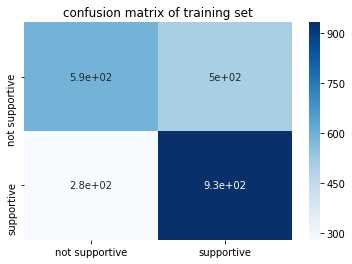

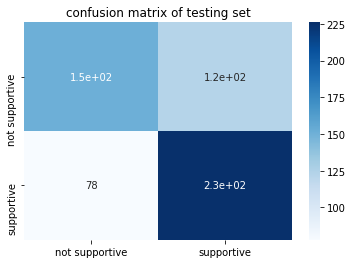


Fold: 2
Accuracy Score: 0.6412478336221837
Precision Score: 0.626984126984127
Recall Score: 0.7821782178217822
f1 Score: 0.6960352422907489
confusion_matrix of training set is: 
 [[593 500]
 [283 930]] 

confusion_matrix of testing set is: 
 [[133 141]
 [ 66 237]] 

             precision    recall  f1-score   support

          0       0.67      0.49      0.56       274
          1       0.63      0.78      0.70       303

avg / total       0.65      0.64      0.63       577



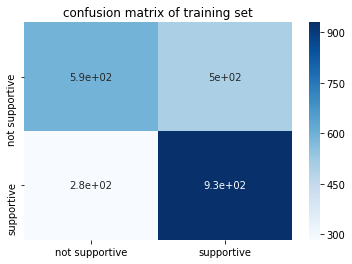

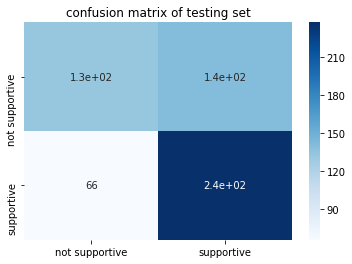


Fold: 3
Accuracy Score: 0.6510416666666666
Precision Score: 0.6457142857142857
Recall Score: 0.7458745874587459
f1 Score: 0.6921898928024501
confusion_matrix of training set is: 
 [[600 494]
 [284 929]] 

confusion_matrix of testing set is: 
 [[149 124]
 [ 77 226]] 

             precision    recall  f1-score   support

          0       0.66      0.55      0.60       273
          1       0.65      0.75      0.69       303

avg / total       0.65      0.65      0.65       576



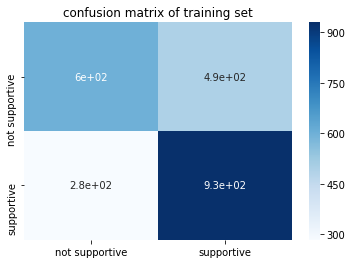

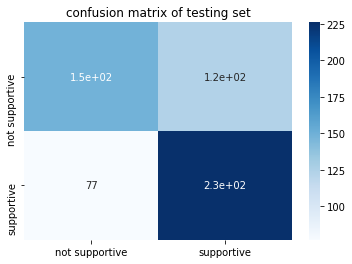


Fold: 4
Accuracy Score: 0.6302083333333334
Precision Score: 0.6216216216216216
Recall Score: 0.759075907590759
f1 Score: 0.6835066864784547
confusion_matrix of training set is: 
 [[573 521]
 [255 958]] 

confusion_matrix of testing set is: 
 [[133 140]
 [ 73 230]] 

             precision    recall  f1-score   support

          0       0.65      0.49      0.56       273
          1       0.62      0.76      0.68       303

avg / total       0.63      0.63      0.62       576



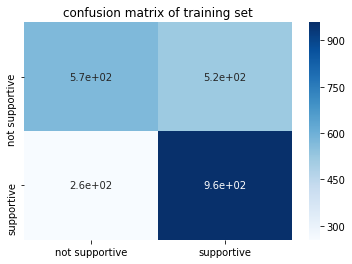

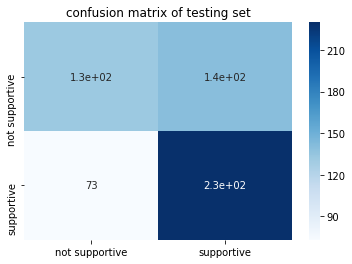


Fold: 5
Accuracy Score: 0.6232638888888888
Precision Score: 0.6242774566473989
Recall Score: 0.7128712871287128
f1 Score: 0.6656394453004622
confusion_matrix of training set is: 
 [[613 481]
 [288 925]] 

confusion_matrix of testing set is: 
 [[143 130]
 [ 87 216]] 

             precision    recall  f1-score   support

          0       0.62      0.52      0.57       273
          1       0.62      0.71      0.67       303

avg / total       0.62      0.62      0.62       576



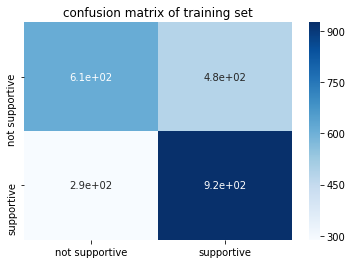

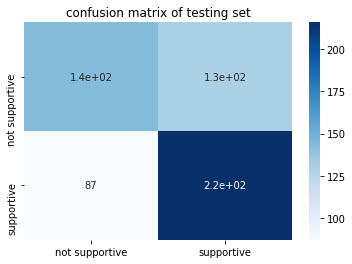

,accuracy,precision,recall,f1
0,0.652249,0.647564,0.743421,0.692190
1,0.641248,0.626984,0.782178,0.696035
2,0.651042,0.645714,0.745875,0.692190
3,0.630208,0.621622,0.759076,0.683507
4,0.623264,0.624277,0.712871,0.665639


In [102]:
k_fold_evaluate(X, y, max_depth=5, min_samples_leaf=2)

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 1093 not supportive tweets in the training set.
There are 1212 supportive tweets in the training set.
There are 274 not supportive tweets in the testing set.
There are 304 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6522491349480969
Precision Score: 0.6442577030812325
Recall Score: 0.756578947368421
f1 Score: 0.6959152798789712
confusion_matrix of training set is: 
 [[581 512]
 [256 956]] 

confusion_matrix of testing set is: 
 [[147 127]
 [ 74 230]] 

             precision    recall  f1-score   support

          0       0.67      0.54      0.59       274
          1       0.64      0.76      0.70       304

avg / total       0.65      0.65      0.65       578



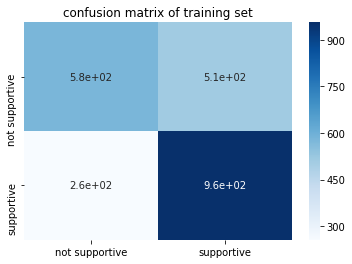

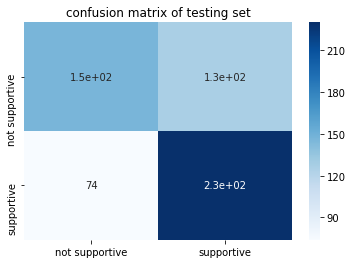


Fold: 2
Accuracy Score: 0.6395147313691508
Precision Score: 0.6259946949602122
Recall Score: 0.7788778877887789
f1 Score: 0.6941176470588235
confusion_matrix of training set is: 
 [[597 496]
 [279 934]] 

confusion_matrix of testing set is: 
 [[133 141]
 [ 67 236]] 

             precision    recall  f1-score   support

          0       0.67      0.49      0.56       274
          1       0.63      0.78      0.69       303

avg / total       0.64      0.64      0.63       577



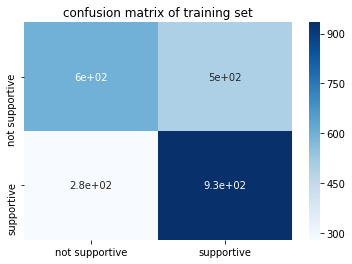

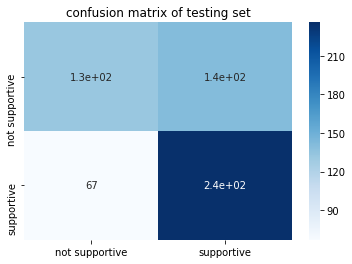


Fold: 3
Accuracy Score: 0.6458333333333334
Precision Score: 0.6426512968299711
Recall Score: 0.735973597359736
f1 Score: 0.6861538461538462
confusion_matrix of training set is: 
 [[604 490]
 [281 932]] 

confusion_matrix of testing set is: 
 [[149 124]
 [ 80 223]] 

             precision    recall  f1-score   support

          0       0.65      0.55      0.59       273
          1       0.64      0.74      0.69       303

avg / total       0.65      0.65      0.64       576



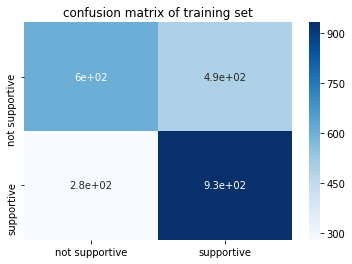

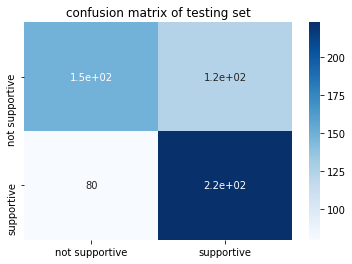


Fold: 4
Accuracy Score: 0.6267361111111112
Precision Score: 0.6189189189189189
Recall Score: 0.7557755775577558
f1 Score: 0.6805349182763745
confusion_matrix of training set is: 
 [[584 510]
 [245 968]] 

confusion_matrix of testing set is: 
 [[132 141]
 [ 74 229]] 

             precision    recall  f1-score   support

          0       0.64      0.48      0.55       273
          1       0.62      0.76      0.68       303

avg / total       0.63      0.63      0.62       576



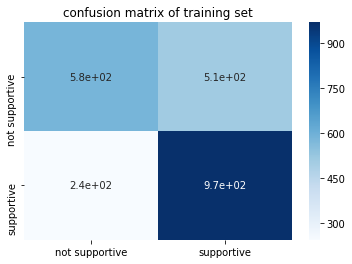

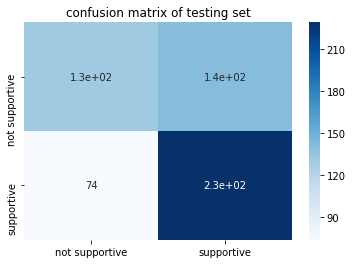


Fold: 5
Accuracy Score: 0.6284722222222222
Precision Score: 0.6275071633237822
Recall Score: 0.7227722772277227
f1 Score: 0.6717791411042944
confusion_matrix of training set is: 
 [[618 476]
 [277 936]] 

confusion_matrix of testing set is: 
 [[143 130]
 [ 84 219]] 

             precision    recall  f1-score   support

          0       0.63      0.52      0.57       273
          1       0.63      0.72      0.67       303

avg / total       0.63      0.63      0.62       576



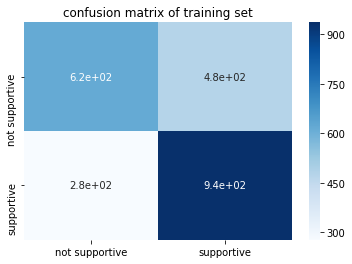

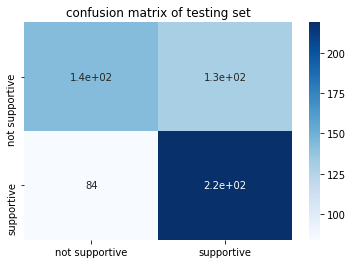

,accuracy,precision,recall,f1
0,0.652249,0.644258,0.756579,0.695915
1,0.639515,0.625995,0.778878,0.694118
2,0.645833,0.642651,0.735974,0.686154
3,0.626736,0.618919,0.755776,0.680535
4,0.628472,0.627507,0.722772,0.671779


In [103]:
k_fold_evaluate(X, y, max_depth=6, min_samples_leaf=2)

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 1093 not supportive tweets in the training set.
There are 1212 supportive tweets in the training set.
There are 274 not supportive tweets in the testing set.
There are 304 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6557093425605537
Precision Score: 0.6454293628808865
Recall Score: 0.7664473684210527
f1 Score: 0.7007518796992481
confusion_matrix of training set is: 
 [[577 516]
 [237 975]] 

confusion_matrix of testing set is: 
 [[146 128]
 [ 71 233]] 

             precision    recall  f1-score   support

          0       0.67      0.53      0.59       274
          1       0.65      0.77      0.70       304

avg / total       0.66      0.66      0.65       578



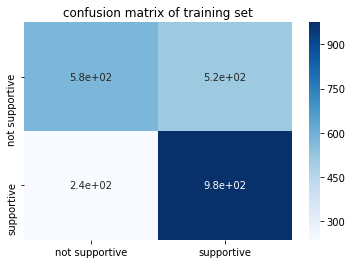

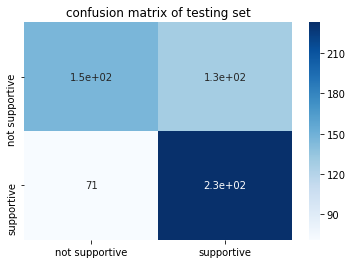


Fold: 2
Accuracy Score: 0.6499133448873483
Precision Score: 0.6311688311688312
Recall Score: 0.801980198019802
f1 Score: 0.7063953488372093
confusion_matrix of training set is: 
 [[600 493]
 [262 951]] 

confusion_matrix of testing set is: 
 [[132 142]
 [ 60 243]] 

             precision    recall  f1-score   support

          0       0.69      0.48      0.57       274
          1       0.63      0.80      0.71       303

avg / total       0.66      0.65      0.64       577



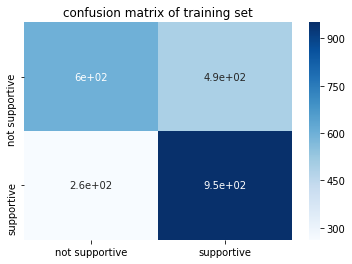

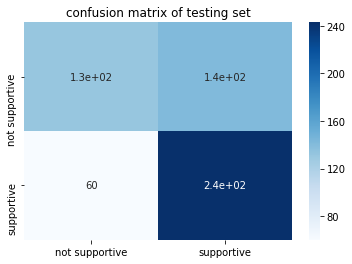


Fold: 3
Accuracy Score: 0.6493055555555556
Precision Score: 0.6446991404011462
Recall Score: 0.7425742574257426
f1 Score: 0.6901840490797546
confusion_matrix of training set is: 
 [[612 482]
 [274 939]] 

confusion_matrix of testing set is: 
 [[149 124]
 [ 78 225]] 

             precision    recall  f1-score   support

          0       0.66      0.55      0.60       273
          1       0.64      0.74      0.69       303

avg / total       0.65      0.65      0.65       576



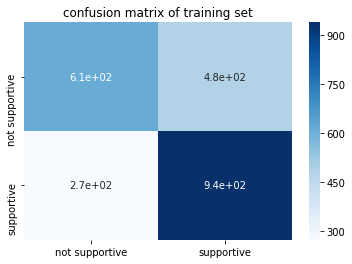

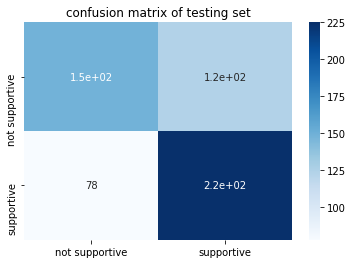


Fold: 4
Accuracy Score: 0.625
Precision Score: 0.6172506738544474
Recall Score: 0.7557755775577558
f1 Score: 0.6795252225519287
confusion_matrix of training set is: 
 [[597 497]
 [235 978]] 

confusion_matrix of testing set is: 
 [[131 142]
 [ 74 229]] 

             precision    recall  f1-score   support

          0       0.64      0.48      0.55       273
          1       0.62      0.76      0.68       303

avg / total       0.63      0.62      0.62       576



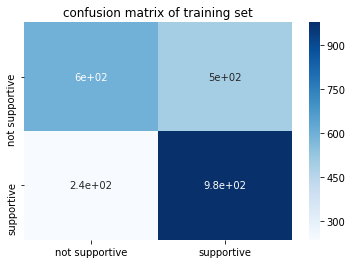

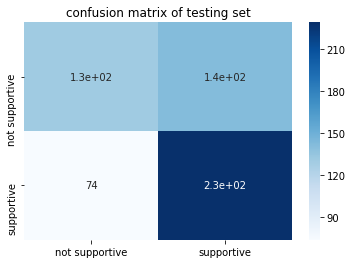


Fold: 5
Accuracy Score: 0.6371527777777778
Precision Score: 0.6284153005464481
Recall Score: 0.759075907590759
f1 Score: 0.6875934230194319
confusion_matrix of training set is: 
 [[589 505]
 [238 975]] 

confusion_matrix of testing set is: 
 [[137 136]
 [ 73 230]] 

             precision    recall  f1-score   support

          0       0.65      0.50      0.57       273
          1       0.63      0.76      0.69       303

avg / total       0.64      0.64      0.63       576



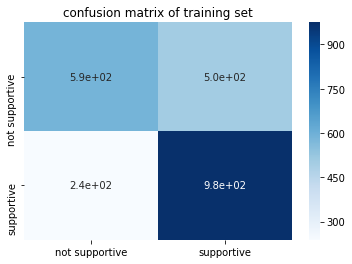

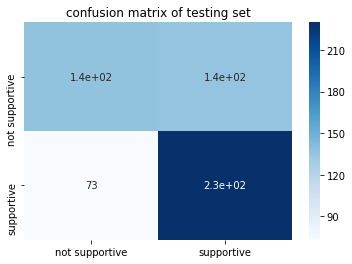

,accuracy,precision,recall,f1
0,0.655709,0.645429,0.766447,0.700752
1,0.649913,0.631169,0.801980,0.706395
2,0.649306,0.644699,0.742574,0.690184
3,0.625000,0.617251,0.755776,0.679525
4,0.637153,0.628415,0.759076,0.687593


In [104]:
k_fold_evaluate(X, y, max_depth=7, min_samples_leaf=1)

### chosen parameters: `max_depth=7, min_samples_leaf=2`

Because the 5-fold f1 score of max_depth=7, min_samples_leaf=2 are better.

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 1093 not supportive tweets in the training set.
There are 1212 supportive tweets in the training set.
There are 274 not supportive tweets in the testing set.
There are 304 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6522491349480969
Precision Score: 0.6434540389972145
Recall Score: 0.7598684210526315
f1 Score: 0.6968325791855204
confusion_matrix of training set is: 
 [[581 512]
 [241 971]] 

confusion_matrix of testing set is: 
 [[146 128]
 [ 73 231]] 

             precision    recall  f1-score   support

          0       0.67      0.53      0.59       274
          1       0.64      0.76      0.70       304

avg / total       0.65      0.65      0.65       578



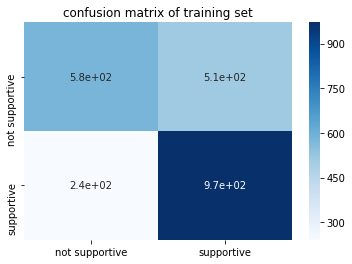

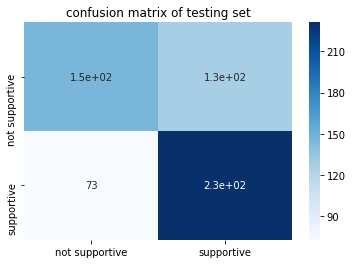


Fold: 2
Accuracy Score: 0.6499133448873483
Precision Score: 0.6311688311688312
Recall Score: 0.801980198019802
f1 Score: 0.7063953488372093
confusion_matrix of training set is: 
 [[597 496]
 [266 947]] 

confusion_matrix of testing set is: 
 [[132 142]
 [ 60 243]] 

             precision    recall  f1-score   support

          0       0.69      0.48      0.57       274
          1       0.63      0.80      0.71       303

avg / total       0.66      0.65      0.64       577



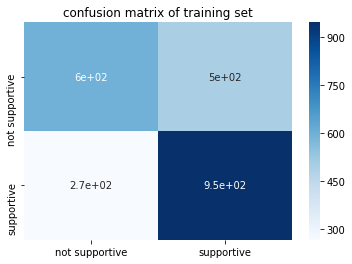

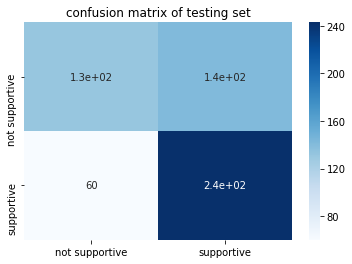


Fold: 3
Accuracy Score: 0.6423611111111112
Precision Score: 0.641399416909621
Recall Score: 0.7260726072607261
f1 Score: 0.6811145510835913
confusion_matrix of training set is: 
 [[611 483]
 [282 931]] 

confusion_matrix of testing set is: 
 [[150 123]
 [ 83 220]] 

             precision    recall  f1-score   support

          0       0.64      0.55      0.59       273
          1       0.64      0.73      0.68       303

avg / total       0.64      0.64      0.64       576



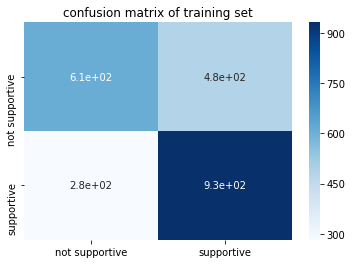

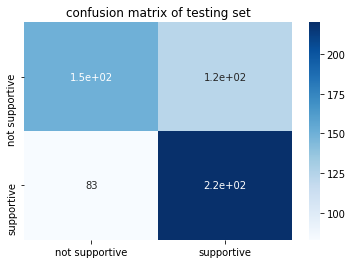


Fold: 4
Accuracy Score: 0.6232638888888888
Precision Score: 0.6168478260869565
Recall Score: 0.7491749174917491
f1 Score: 0.676602086438152
confusion_matrix of training set is: 
 [[597 497]
 [242 971]] 

confusion_matrix of testing set is: 
 [[132 141]
 [ 76 227]] 

             precision    recall  f1-score   support

          0       0.63      0.48      0.55       273
          1       0.62      0.75      0.68       303

avg / total       0.63      0.62      0.62       576



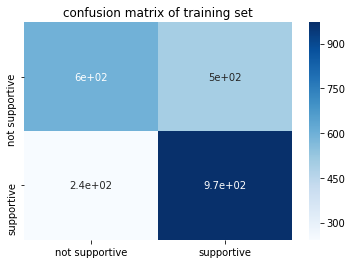

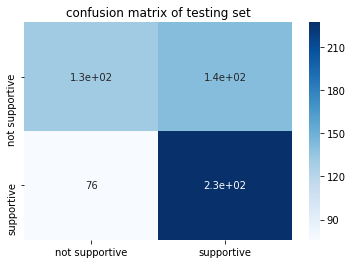


Fold: 5
Accuracy Score: 0.6388888888888888
Precision Score: 0.6294277929155313
Recall Score: 0.7623762376237624
f1 Score: 0.68955223880597
confusion_matrix of training set is: 
 [[588 506]
 [241 972]] 

confusion_matrix of testing set is: 
 [[137 136]
 [ 72 231]] 

             precision    recall  f1-score   support

          0       0.66      0.50      0.57       273
          1       0.63      0.76      0.69       303

avg / total       0.64      0.64      0.63       576



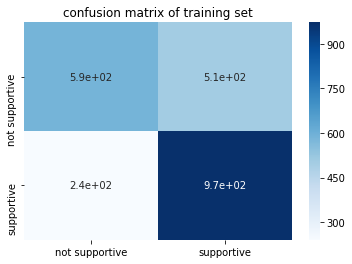

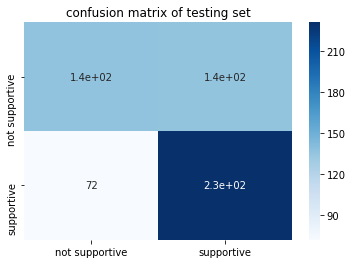

,accuracy,precision,recall,f1
0,0.652249,0.643454,0.759868,0.696833
1,0.649913,0.631169,0.801980,0.706395
2,0.642361,0.641399,0.726073,0.681115
3,0.623264,0.616848,0.749175,0.676602
4,0.638889,0.629428,0.762376,0.689552


In [117]:
k_fold_evaluate(X, y, max_depth=7, min_samples_leaf=2)

### reload pickle

In [115]:
clf2 = joblib.load('ClimateTeam7PD2.pkl')
y_pred = clf2.predict(X)
f1_score(y_pred, y)

0.7156454491374182